In [113]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.svm import SVC
from scipy.spatial.distance import cdist

In [115]:
def rbf_kernel(X1, X2, gamma=0.1):
    return np.exp(-gamma * cdist(X1, X2, 'sqeuclidean'))

def dual_objective(alpha, y, K):
    return 0.5 * np.sum((alpha[:, None] * alpha[None, :] * y[:, None] * y[None, :] * K)) - np.sum(alpha)

K = rbf_kernel(X, X, gamma=0.1)

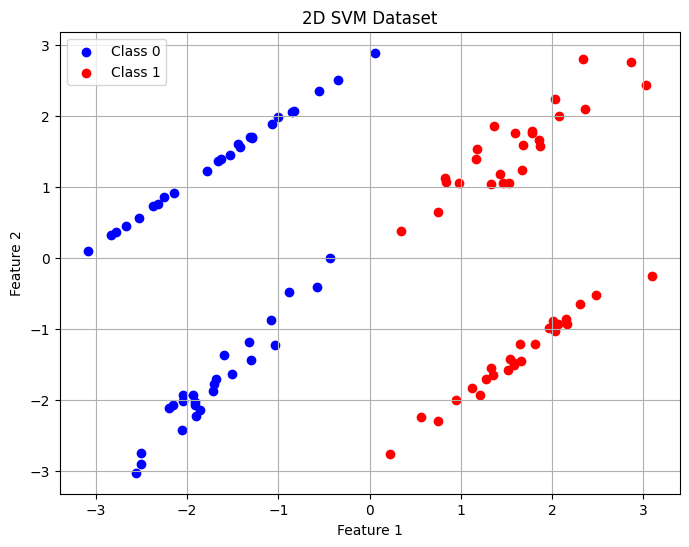

In [117]:
X, y = make_classification(
    n_samples=100,        # Number of points
    n_features=2,         # Two features (2D)
    n_redundant=0,        # No redundant features
    n_clusters_per_class=2,
    class_sep=1.5,        # Separation between classes
    random_state=42
)
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D SVM Dataset')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
y = np.where(y == 0, -1, 1)

C = 2.5  # Regularization parameter
n_samples = X.shape[0]

# Constraint: sum(alpha_i * y_i) == 0
constraints = {
    'type': 'eq',
    'fun': lambda alpha: np.dot(alpha, y)
}

# Bounds: 0 <= alpha_i <= C
bounds = [(0, C) for _ in range(n_samples)]

# Initial guess
initial_alpha = np.zeros(n_samples)


In [131]:
result = minimize(
    fun=dual_objective,
    x0=initial_alpha,
    args=(y, K),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'disp': True, 'maxiter': 1000}
)

alphas = result.x
print(alphas)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.235690251955806
            Iterations: 26
            Function evaluations: 2629
            Gradient evaluations: 26
[2.50000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.67065316e-15 2.50000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.92365772e-16 2.50000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21476675e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50000000e+00 0.00000000e+00 0.00000000e+00
 1.85612978e-15 2.02569308e-13 0.00000000e+00 8.70895657e-01
 0.00000000e+00 0.00000000e+00 9.94403673e-16 0.00000000e+00
 0.00000000e+00 1.11272900e-15 0.00000000e+00 0.00000000e+00
 2.50000000e+00 0.00000000e+00 4.83515494e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.60286216e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0000000

In [122]:
# Support vectors: alphas > threshold
support_vector_indices = np.where(alphas > 1e-5)[0]
support_vectors = X[support_vector_indices]
support_alphas = alphas[support_vector_indices]
support_y = y[support_vector_indices]

# Compute bias (b)
def compute_bias(X, y, alphas, K, support_indices):
    idx = support_indices[0]
    return y[idx] - np.sum(alphas * y * K[idx])

b = compute_bias(X, y, alphas, K, support_vector_indices)

# Predict function
def predict(X_test, X_train, y_train, alphas, b, gamma=0.1):
    K_test = rbf_kernel(X_test, X_train, gamma)
    return np.sign(np.sum(alphas * y_train * K_test, axis=1) + b)

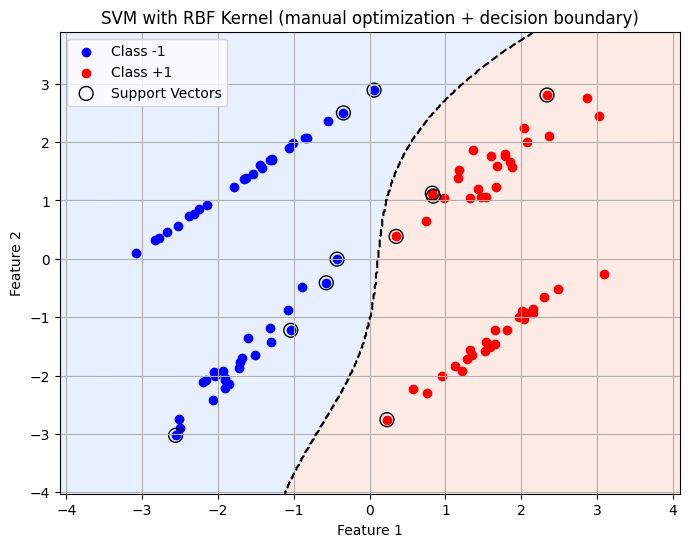

In [125]:
# Create a meshgrid over the plot space
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Flatten and predict using the manual model
grid = np.c_[xx.ravel(), yy.ravel()]
Z_manual = predict(grid, X, y, alphas, b, gamma=0.1)
Z_manual = Z_manual.reshape(xx.shape)

# Plot everything
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_manual, alpha=0.2, levels=np.linspace(-1, 1, 3), cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z_manual, levels=[0], linestyles='--', colors='k')  # Decision boundary

plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='blue', label='Class -1')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red', label='Class +1')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=100, facecolors='none', edgecolors='k', label='Support Vectors')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with RBF Kernel (manual optimization + decision boundary)')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
clf = SVC(kernel='rbf', gamma=0.1)
clf.fit(X, y)
clf.score(X, y)
params = clf.get_params()

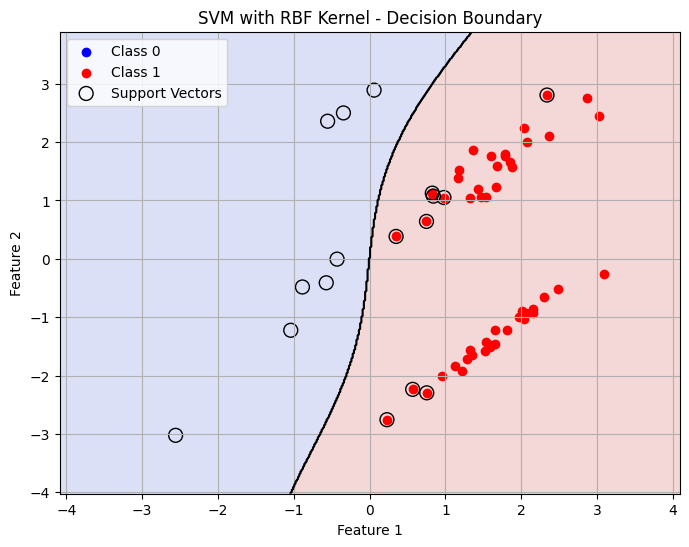

In [129]:
plt.figure(figsize=(8, 6))

# Create a meshgrid for plotting decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z, levels=[0.5], linestyles=['-'], colors='k')

# Plot training points
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red', label='Class 1')

# Highlight support vectors
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Labels and styling
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with RBF Kernel - Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()